--- MAML Training (0 to 2000) ---
MAML Epoch 0 | Meta Loss: 0.7206
MAML Epoch 200 | Meta Loss: 0.2990
MAML Epoch 400 | Meta Loss: 0.3186
MAML Epoch 600 | Meta Loss: 0.2891
MAML Epoch 800 | Meta Loss: 0.3312
MAML Epoch 1000 | Meta Loss: 0.2990
MAML Epoch 1200 | Meta Loss: 0.3097
MAML Epoch 1400 | Meta Loss: 0.3126
MAML Epoch 1600 | Meta Loss: 0.2773
MAML Epoch 1800 | Meta Loss: 0.3052
MAML Epoch 2000 | Meta Loss: 0.3028

--- Baseline Training (0 to 2000) ---
Baseline Epoch 0 | Loss: 0.4618
Baseline Epoch 200 | Loss: 0.3350
Baseline Epoch 400 | Loss: 0.3149
Baseline Epoch 600 | Loss: 0.3731
Baseline Epoch 800 | Loss: 0.3397
Baseline Epoch 1000 | Loss: 0.3960
Baseline Epoch 1200 | Loss: 0.2329
Baseline Epoch 1400 | Loss: 0.3363
Baseline Epoch 1600 | Loss: 0.3706
Baseline Epoch 1800 | Loss: 0.2991
Baseline Epoch 2000 | Loss: 0.2762


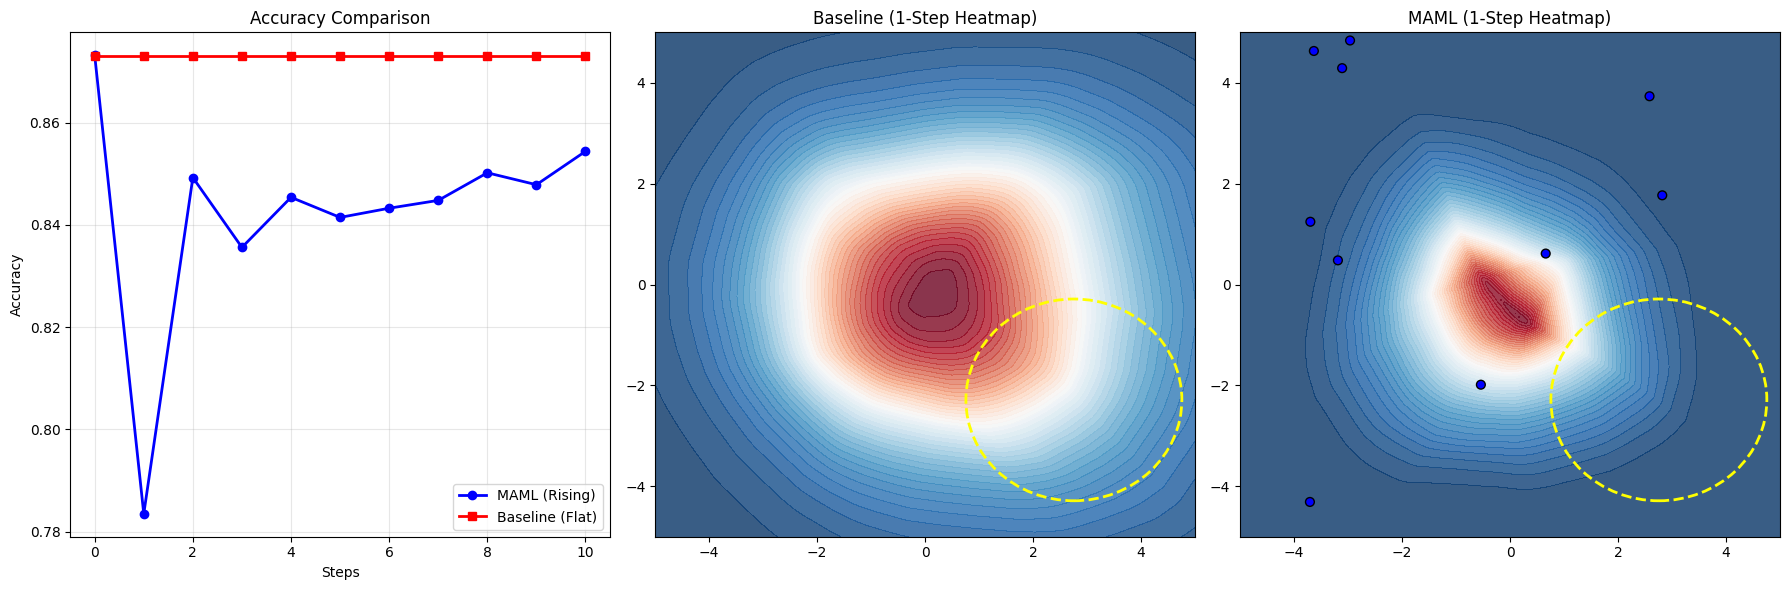

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Dataset Generator
def create_task(K=10, Q=150):
    radius = 2.0
    cx, cy = np.random.uniform(-3, 3, 2)
    def sample(n):
        x = np.random.uniform(-5, 5, (n, 2))
        y = (np.sqrt((x[:,0]-cx)**2 + (x[:,1]-cy)**2) < radius).astype(np.float32)
        return torch.tensor(x, dtype=torch.float32).to(device), \
               torch.tensor(y.reshape(-1,1), dtype=torch.float32).to(device)
    return *sample(K), *sample(Q), (cx, cy)

# 2. Model
class CircleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, params=None):
        if params is None:
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            return torch.sigmoid(self.fc3(x))
        else:
            x = torch.nn.functional.linear(x, params[0], params[1])
            x = torch.relu(x)
            x = torch.nn.functional.linear(x, params[2], params[3])
            x = torch.relu(x)
            x = torch.nn.functional.linear(x, params[4], params[5])
            return torch.sigmoid(x)

# 3. MAML Training
maml_model = CircleNet().to(device)
meta_optimizer = optim.Adam(maml_model.parameters(), lr=0.001)

print("--- MAML Training (0 to 2000) ---")
for epoch in range(2001):
    meta_loss = 0
    for _ in range(16):
        sx, sy, qx, qy, _ = create_task(K=10)
        # Inner loop
        preds = maml_model(sx)
        inner_loss = nn.BCELoss()(preds, sy)
        grads = torch.autograd.grad(inner_loss, maml_model.parameters(), create_graph=True)
        adapted_params = [p - 0.01 * g for p, g in zip(maml_model.parameters(), grads)]
        # Outer loop
        meta_loss += nn.BCELoss()(maml_model(qx, adapted_params), qy)

    meta_optimizer.zero_grad()
    (meta_loss/16).backward()
    meta_optimizer.step()
    if epoch % 200 == 0: print(f"MAML Epoch {epoch} | Meta Loss: {meta_loss.item()/16:.4f}")

# 4. Baseline Training (Joint Training)
baseline_model = CircleNet().to(device)
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

print("\n--- Baseline Training (0 to 2000) ---")
for epoch in range(2001):
    sx, sy, _, _, _ = create_task(K=128) # Mixed data
    loss = nn.BCELoss()(baseline_model(sx), sy)
    baseline_optimizer.zero_grad(); loss.backward(); baseline_optimizer.step()
    if epoch % 200 == 0: print(f"Baseline Epoch {epoch} | Loss: {loss.item():.4f}")

# 5. Evaluation
def evaluate_acc(model, is_maml=True):
    all_accs = []
    for _ in range(100):
        sx, sy, qx, qy, _ = create_task(K=10)
        m = copy.deepcopy(model)
        # MAML needs high LR to show adaptation, Baseline stays flat with low LR
        optimizer = optim.SGD(m.parameters(), lr=0.1 if is_maml else 0.01)
        task_accs = []
        for s in range(11):
            with torch.no_grad():
                acc = ((m(qx) > 0.5).float() == qy).float().mean().item()
                task_accs.append(acc)
            nn.BCELoss()(m(sx), sy).backward()
            optimizer.step(); optimizer.zero_grad()
        all_accs.append(task_accs)
    return np.mean(all_accs, axis=0)

maml_acc = evaluate_acc(maml_model, True)
base_acc = evaluate_acc(baseline_model, False)

# 6. SHARP GRAPHS & HEATMAPS
plt.figure(figsize=(18, 6))

# Subplot 1: Accuracy Curve
plt.subplot(1, 3, 1)
plt.plot(range(11), maml_acc, 'o-', label="MAML (Rising)", color='blue', linewidth=2)
plt.plot(range(11), base_acc, 's-', label="Baseline (Flat)", color='red', linewidth=2)
plt.xlabel("Steps"); plt.ylabel("Accuracy"); plt.title("Accuracy Comparison")
plt.legend(); plt.grid(True, alpha=0.3)

# Subplot 2 & 3: Heatmaps
sx, sy, qx, qy, (cx, cy) = create_task(K=10)
x_lin = np.linspace(-5, 5, 150)
xx, yy = np.meshgrid(x_lin, x_lin)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

def get_plot_data(model, lr_val):
    m = copy.deepcopy(model)
    opt = optim.SGD(m.parameters(), lr=lr_val)
    nn.BCELoss()(m(sx), sy).backward()
    opt.step()
    with torch.no_grad(): return m(grid).cpu().numpy().reshape(xx.shape)

# Baseline Heatmap
plt.subplot(1, 3, 2)
plt.contourf(xx, yy, get_plot_data(baseline_model, 0.01), levels=50, cmap='RdBu_r', alpha=0.8)
plt.gca().add_patch(plt.Circle((cx, cy), 2.0, color='yellow', fill=False, lw=2, ls='--'))
plt.title("Baseline (1-Step Heatmap)")

# MAML Heatmap
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, get_plot_data(maml_model, 0.1), levels=50, cmap='RdBu_r', alpha=0.8)
plt.scatter(sx.cpu()[:,0], sx.cpu()[:,1], c=sy.cpu().flatten(), cmap='bwr', edgecolors='k', s=40)
plt.gca().add_patch(plt.Circle((cx, cy), 2.0, color='yellow', fill=False, lw=2, ls='--'))
plt.title("MAML (1-Step Heatmap)")

plt.tight_layout(); plt.show()